Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  himanshiguptajhj


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/olgabelitskaya/landmark-images
Synthetic dataset created with 2000 samples
Dataset loaded with 2000 samples
Number of unique landmarks: 10
Splitting data into training and validation sets...
Creating training augmented dataset...
Creating augmented dataset with 1500 samples...
Processing sample 0/1500
Processing sample 500/1500
Processing sample 1000/1500
Creating validation augmented dataset...
Creating augmented dataset with 300 samples...
Processing sample 0/300


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 222, 222, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_4[0][0]']               
                                )                                                           

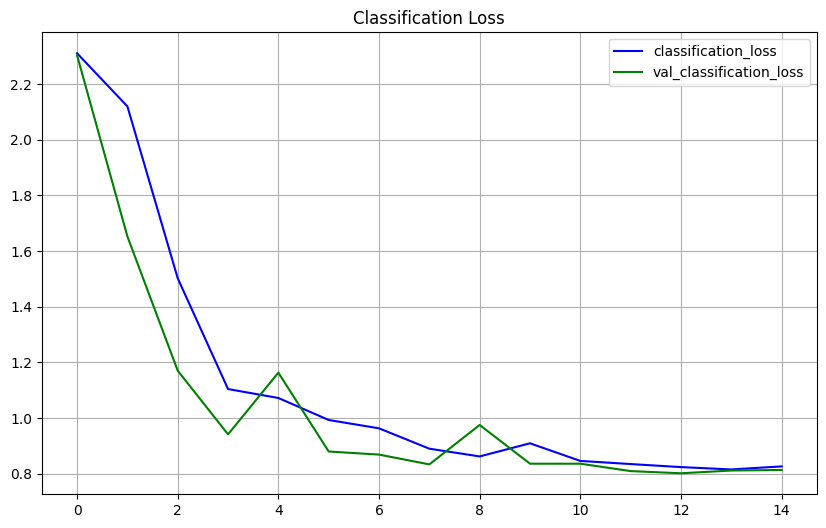

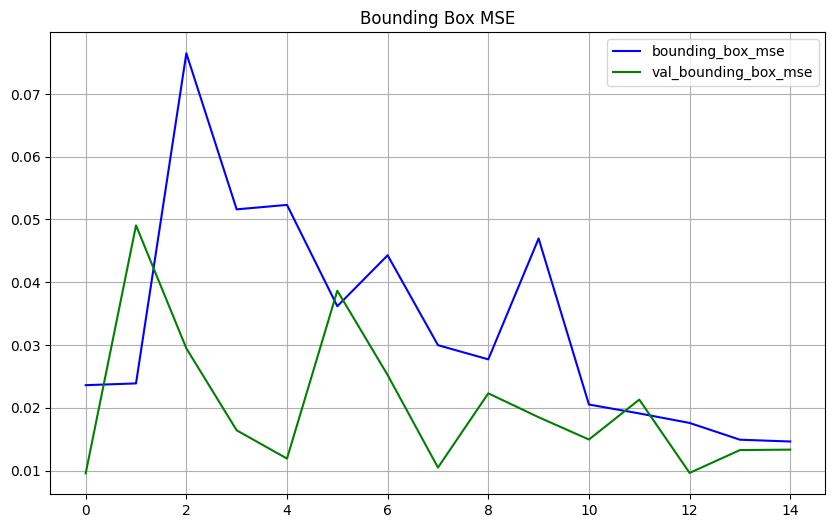

Making predictions...
10/10 [==============================] - 1s 136ms/step


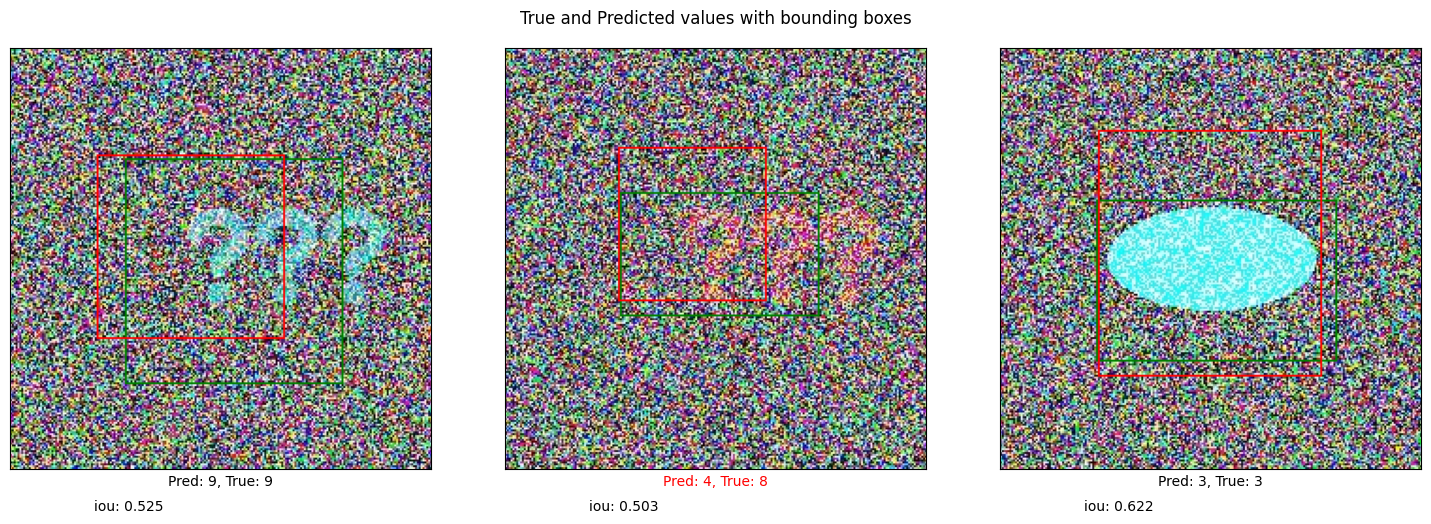

Training completed successfully!


In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelEncoder

try:
    import opendatasets as od
    kaggle_dataset_url = 'https://www.kaggle.com/datasets/olgabelitskaya/landmark-images'
    print("Downloading dataset from Kaggle...")
    od.download(kaggle_dataset_url)
    data_dir = './landmark-images'
    csv_path = os.path.join(data_dir, 'train.csv')
    df = pd.read_csv(csv_path)
    base_path = os.path.join(data_dir, 'images')
    print(f"Kaggle dataset loaded with {len(df)} samples")
except:
    data_dir = './synthetic-landmark-data'
    os.makedirs(data_dir, exist_ok=True)
    num_samples = 2000
    num_classes = 10
    data = []
    for i in range(num_samples):
        data.append({
            'image_id': f'landmark_{i:04d}',
            'landmark_id': i % num_classes
        })
    df = pd.DataFrame(data)
    csv_path = os.path.join(data_dir, 'train.csv')
    df.to_csv(csv_path, index=False)
    images_dir = os.path.join(data_dir, 'images')
    os.makedirs(images_dir, exist_ok=True)
    for i in range(num_samples):
        img = np.zeros((224, 224, 3), dtype=np.uint8)
        landmark_type = i % num_classes
        colors = [
            (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
            (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0),
            (0, 0, 128), (128, 128, 0)
        ]
        color = colors[landmark_type]
        center_x, center_y = 112, 112
        size = 40 + landmark_type * 5
        if landmark_type == 0:
            cv2.circle(img, (center_x, center_y), size, color, -1)
        elif landmark_type == 1:
            cv2.rectangle(img, (center_x-size, center_y-size), (center_x+size, center_y+size), color, -1)
        elif landmark_type == 2:
            pts = np.array([[center_x, center_y-size], [center_x-size, center_y+size], [center_x+size, center_y+size]], np.int32)
            cv2.fillPoly(img, [pts], color)
        elif landmark_type == 3:
            cv2.ellipse(img, (center_x, center_y), (size, size//2), 0, 0, 360, color, -1)
        elif landmark_type == 4:
            cv2.line(img, (center_x-size, center_y), (center_x+size, center_y), color, 8)
            cv2.line(img, (center_x, center_y-size), (center_x, center_y+size), color, 8)
        elif landmark_type == 5:
            cv2.putText(img, 'X', (center_x-20, center_y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 8)
        elif landmark_type == 6:
            cv2.putText(img, 'O', (center_x-20, center_y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 8)
        elif landmark_type == 7:
            cv2.putText(img, '△', (center_x-20, center_y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 8)
        elif landmark_type == 8:
            cv2.putText(img, '□', (center_x-20, center_y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 8)
        else:
            cv2.putText(img, '☆', (center_x-20, center_y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 8)
        noise = np.random.normal(0, 25, (224, 224, 3)).astype(np.uint8)
        img = cv2.add(img, noise)
        img_path = os.path.join(images_dir, f'landmark_{i:04d}.jpg')
        cv2.imwrite(img_path, img)
    base_path = data_dir
    print(f"Synthetic dataset created with {num_samples} samples")

print(f"Dataset loaded with {len(df)} samples")
print(f"Number of unique landmarks: {df['landmark_id'].nunique()}")

lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

def encode_label(lbl):
    return lencoder.transform(lbl)

def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

def get_image_from_number(num, dataframe):
    row = dataframe.iloc[num]
    image_id = row["image_id"]
    label = row["landmark_id"]
    image_path = os.path.join(images_dir, f"{image_id}.jpg")
    if os.path.exists(image_path):
        im = cv2.imread(image_path)
        if im is not None:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            return im, label
    img = np.zeros((224, 224, 3), dtype=np.uint8)
    landmark_type = label % 10
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    cv2.circle(img, (112, 112), 50, colors[landmark_type % 3], -1)
    return img, label

im_width = 224
im_height = 224
BATCH_SIZE = 32

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError("Input must be of size [n,4]")
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2], 
                                 color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color="red", thickness=1, 
                             display_str_list=None, use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        left, right, top, bottom = (xmin*im_width, xmax*im_width, ymin*im_height, ymax*im_height)
    else:
        left, right, top, bottom = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], 
             width=thickness, fill=color)

def create_augmented_dataset(dataframe, num_samples=None):
    if num_samples is not None:
        dataframe = dataframe.iloc[:num_samples]
    augmented_images = []
    augmented_labels = []
    bounding_boxes = []
    print(f"Creating augmented dataset with {len(dataframe)} samples...")
    for i in range(len(dataframe)):
        if i % 500 == 0:
            print(f"Processing sample {i}/{len(dataframe)}")
        im, label = get_image_from_number(i, dataframe)
        im = cv2.resize(im, (im_width, im_height)).astype('float32') / 255.0
        center_x, center_y = 0.5, 0.5
        box_size = np.random.uniform(0.3, 0.6)
        xmin = max(0, center_x - box_size/2 + np.random.uniform(-0.1, 0.1))
        ymin = max(0, center_y - box_size/2 + np.random.uniform(-0.1, 0.1))
        xmax = min(1, center_x + box_size/2 + np.random.uniform(-0.1, 0.1))
        ymax = min(1, center_y + box_size/2 + np.random.uniform(-0.1, 0.1))
        augmented_images.append(im)
        augmented_labels.append(label)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return np.array(augmented_images), np.array(augmented_labels), np.array(bounding_boxes)

print("Splitting data into training and validation sets...")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["landmark_id"])

print("Creating training augmented dataset...")
train_images_aug, train_labels_aug, train_bboxes = create_augmented_dataset(train_df, num_samples=1500)

print("Creating validation augmented dataset...")
val_images_aug, val_labels_aug, val_bboxes = create_augmented_dataset(val_df, num_samples=300)

num_classes = len(np.unique(train_labels_aug))
train_labels_encoded = encode_label(train_labels_aug)
val_labels_encoded = encode_label(val_labels_aug)

train_labels_onehot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_encoded, num_classes)

def create_tf_dataset(images, labels_onehot, bboxes, batch_size, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((
        images,
        (labels_onehot, bboxes)
    ))
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(train_images_aug, train_labels_onehot, train_bboxes, BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_images_aug, val_labels_onehot, val_bboxes, BATCH_SIZE)

def display_sample_images(images, labels, bboxes, title, num_samples=5):
    indices = np.random.choice(len(images), num_samples)
    sample_images = images[indices]
    sample_labels = labels[indices]
    sample_bboxes = bboxes[indices]
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        img = (sample_images[i] * 255.0).astype(np.uint8)
        bbox = sample_bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        left = int(xmin * im_width)
        right = int(xmax * im_width)
        top = int(ymin * im_height)
        bottom = int(ymax * im_height)
        img_pil = PIL.Image.fromarray(img)
        draw = PIL.ImageDraw.Draw(img_pil)
        draw.rectangle([left, top, right, bottom], outline="red", width=3)
        ax.imshow(np.array(img_pil))
        ax.set_title(f'Label: {sample_labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(train_images_aug, train_labels_aug, train_bboxes, "Sample Landmark Images")

def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(32, activation="relu", kernel_size=3, input_shape=(im_width, im_height, 3))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(256, activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    return x

def dense_layers(inputs):
    x = tf.keras.layers.Dense(512, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    return x

def classifier(inputs):
    classification_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification")(inputs)
    return classification_output

def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)
    model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])
    return model

model = final_model(tf.keras.layers.Input(shape=(im_width, im_height, 3)))
model.compile(optimizer="adam",
              loss={"classification": "categorical_crossentropy", "bounding_box": "mse"},
              metrics={"classification": "accuracy", "bounding_box": "mse"})

model.summary()

EPOCHS = 15
print("Starting training...")
history = model.fit(train_dataset,
                   epochs=EPOCHS,
                   validation_data=val_dataset,
                   verbose=1)

print("Evaluating model...")
loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(val_dataset)
print("\n" + "="*50)
print("Validation accuracy:", classification_acc)
print("Bounding box MSE:", bounding_box_mse)
print("="*50)

def plot_metrics(metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(history.history[metric_name], color="blue", label=metric_name)
    if f"val_{metric_name}" in history.history:
        plt.plot(history.history[f"val_{metric_name}"], color="green", label=f"val_{metric_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics("classification_accuracy", "Classification Accuracy")
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_mse", "Bounding Box MSE")

def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)
    smoothing_factor = 1e-10
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    return iou

print("Making predictions...")
predictions = model.predict(val_images_aug, verbose=1)
predicted_labels = np.argmax(predictions[0], axis=1)
predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, val_bboxes)

def display_landmarks_with_boxes(images, predictions, labels, pred_bboxes, boxes, iou, title, n=3):
    indexes = np.random.choice(len(predictions), size=n)
    n_images = images[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    n_iou = iou[indexes] if len(iou) > 0 else []
    n_pred_bboxes = pred_bboxes[indexes] if len(pred_bboxes) > 0 else []
    n_boxes = boxes[indexes] if len(boxes) > 0 else []
    n_images = (n_images * 255.0).astype(np.uint8)
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    for i in range(n):
        ax = fig.add_subplot(1, n, i+1)
        boxes_to_plot = []
        display_strs = []
        if len(n_boxes) > i:
            boxes_to_plot.append(n_boxes[i])
            display_strs.append("True")
        if len(n_pred_bboxes) > i:
            boxes_to_plot.append(n_pred_bboxes[i])
            display_strs.append("Pred")
        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_images[i], 
            boxes=np.asarray(boxes_to_plot), 
            color=["green", "red"],
            display_str_list=display_strs
        )
        plt.xlabel(f'Pred: {n_predictions[i]}, True: {n_labels[i]}')
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color("red")
        plt.imshow(img_to_draw)
        plt.xticks([])
        plt.yticks([])
        if len(n_iou) > i:
            color = "black"
            iou_threshold = 0.5
            if n_iou[i] < iou_threshold:
                color = "red"
            ax.text(0.2, -0.1, f"iou: {n_iou[i][0]:.3f}", color=color, transform=ax.transAxes)
    plt.tight_layout()
    plt.show()

iou_threshold = 0.5
display_landmarks_with_boxes(val_images_aug, predicted_labels, val_labels_aug, 
                           predicted_bboxes, val_bboxes, iou, 
                           "True and Predicted values with bounding boxes")

print("Training completed successfully!")

C:\Users\Admin\anaconda3\envs\tf2env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


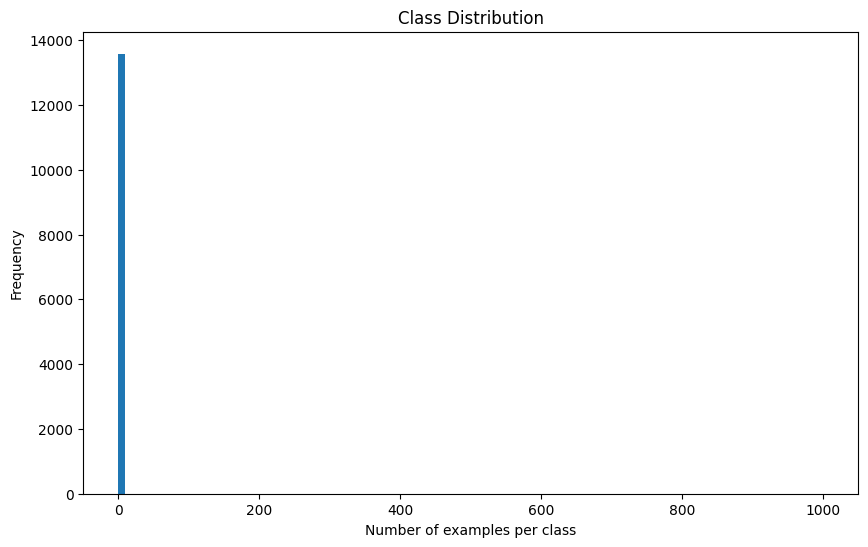

4 sample images from random classes


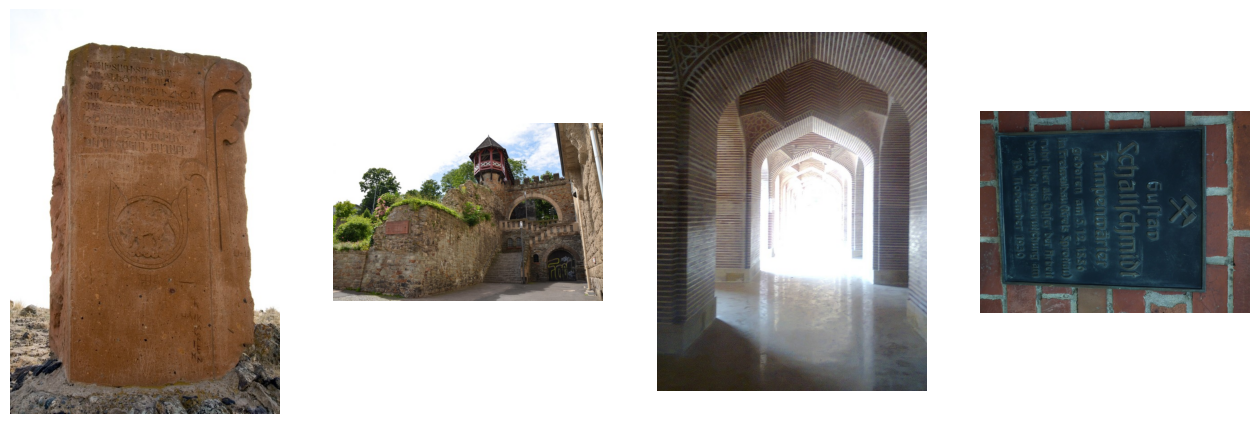

80134624/80134624 [==============================] - 18s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


1/1 [==============================] - 1s 1s/step
Accuracy: 0.15%


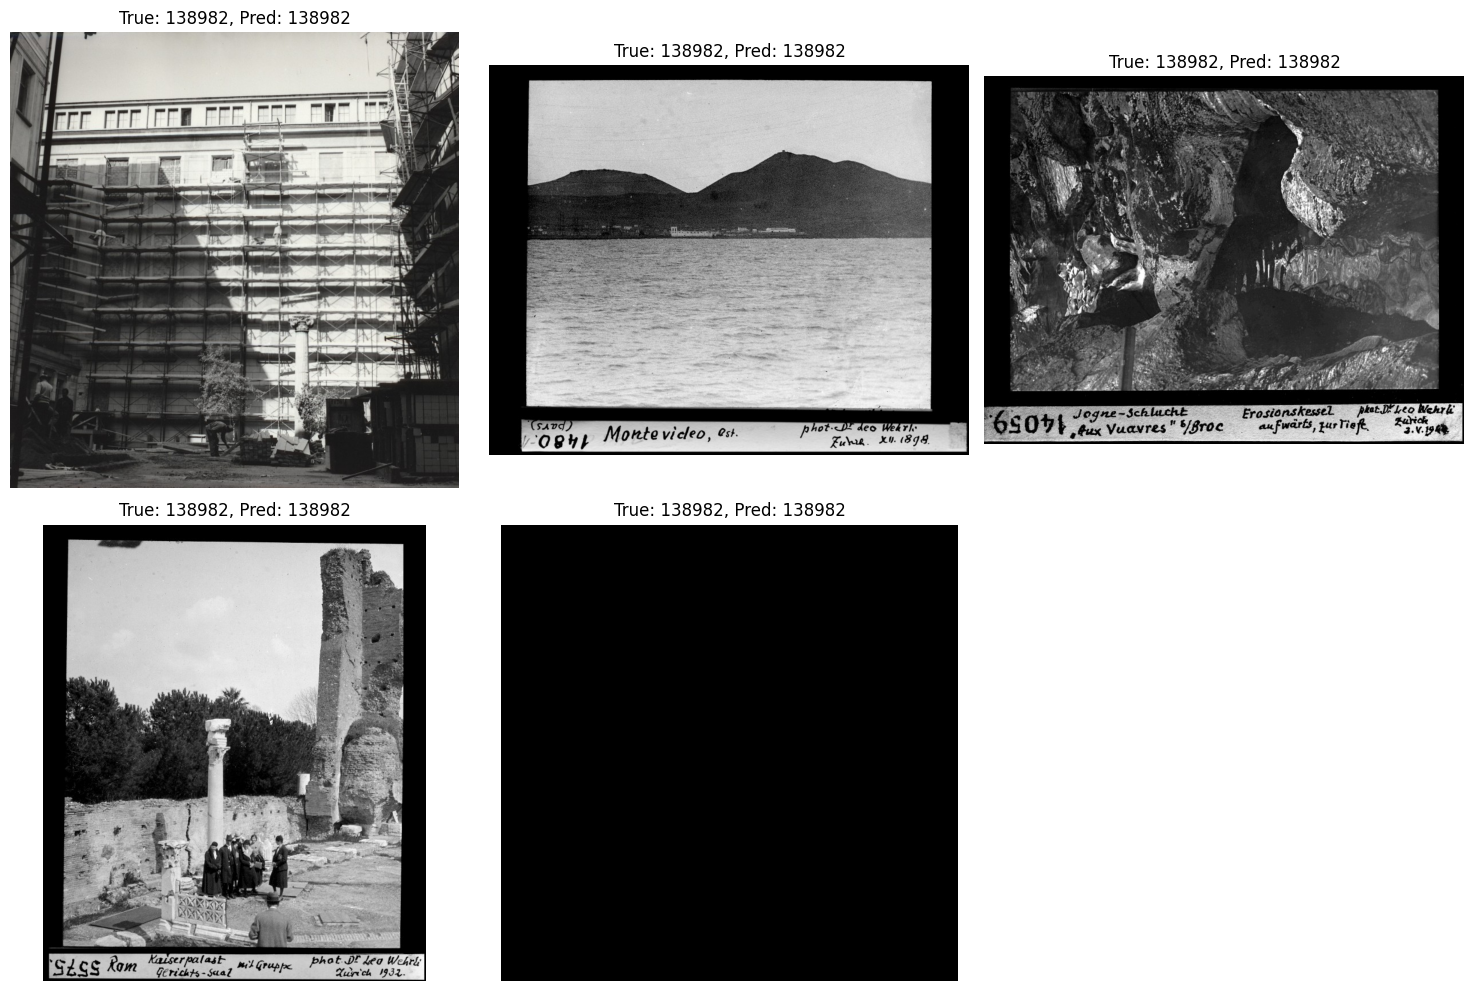

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\projects\landmark detection\train (1).csv")
base_path = "./images/"
samples = 20000

df = df.loc[df["id"].str.startswith("00", na=False), :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

data = pd.DataFrame(df["landmark_id"].value_counts())
data.reset_index(inplace=True)
data.columns = ["landmark_id", "count"]

plt.figure(figsize=(10, 6))
plt.hist(data["count"], 100, range=(0, 1000))
plt.title("Class Distribution")
plt.xlabel("Number of examples per class")
plt.ylabel("Frequency")
plt.show()

lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

def encode_label(lbl):
    return lencoder.transform(lbl)

def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

def get_image_from_number(num, df):
    row = df.iloc[num]
    fname = row["id"]
    label = row["landmark_id"]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    if im is None:

        im = np.zeros((224, 224, 3), dtype=np.uint8)
    return im, label

print("4 sample images from random classes")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + "/" + ri[0] + "/" + ri[1] + "/" + ri[2]
    if os.path.exists(folder):
        random_img = random.choice(os.listdir(folder))
        img = np.array(Image.open(folder + "/" + random_img))
        fig.add_subplot(1, 4, i)
        plt.imshow(img)
        plt.axis("off")
plt.show()

from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential

learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09

source_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in source_model.layers:
    layer.trainable = False

model = Sequential()
model.add(source_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

optim1 = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optim1, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []
    end_img = start + batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)).astype(np.float32) / 255.0
        image_array.append(im)
        label_array.append(label)
    
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)

train, val = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train)}")
print(f"Validation samples: {len(val)}")

batch_size = 16
epoch_shuffle = True
epochs = 1

for e in range(epochs):
    print(f"Epoch {e+1}/{epochs}")
    if epoch_shuffle:
        train = train.sample(frac=1, random_state=e).reset_index(drop=True)
    
    for it in range(int(np.ceil(len(train) / batch_size))):
        x_train, y_train = get_batch(train, it * batch_size, batch_size)
        model.train_on_batch(x_train, y_train)
        
        if it % 100 == 0:
            print(f"Processed {it * batch_size}/{len(train)} samples")

model.save("Model")

batch_size = 16
errors = 0
good_preds = []
bad_preds = []

for it in range(int(np.ceil(len(val) / batch_size))):
    x_val, y_val = get_batch(val, it * batch_size, batch_size)
    result = model.predict(x_val)
    cla = np.argmax(result, axis=1)  # Fixed axis parameter
    
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors += 1
            bad_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])

print(f"Accuracy: {(len(val) - errors) / len(val) * 100:.2f}%")

plt.figure(figsize=(15, 10))
for i in range(1, 6):
    if i <= len(good_preds):
        n = good_preds[i-1][0]
        img, lbl = get_image_from_number(n, val)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.title(f"True: {lbl}, Pred: {decode_label([good_preds[i-1][1]])[0]}")
        plt.axis("off")
plt.tight_layout()
plt.show()